<a href="https://colab.research.google.com/github/caroljiao/Mastering-Big-Data-Analytics-with-PySpark/blob/master/Copy_of_SLR_Project_Cars4U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note: This is a sample solution for the project. Projects will NOT be graded on the basis of how well the submission matches this sample solution. Projects will be graded on the basis of the rubric only.

## Context

There is a huge demand for used cars in the Indian Market today. As sales of new cars have slowed down in the recent past, the pre-owned car market has continued to grow over the past years and is larger than the new car market now. Cars4U is a budding tech start-up that aims to find footholes in this market.

In 2018-19, while new car sales were recorded at 3.6 million units, around 4 million second-hand cars were bought and sold. There is a slowdown in new car sales and that could mean that the demand is shifting towards the pre-owned market. In fact, some car sellers replace their old cars with pre-owned cars instead of buying new ones. Unlike new cars, where price and supply are fairly deterministic and managed by OEMs (Original Equipment Manufacturer / except for dealership level discounts which come into play only in the last stage of the customer journey), used cars are very different beasts with huge uncertainty in both pricing and supply. Keeping this in mind, the pricing scheme of these used cars becomes important in order to grow in the market.

As a senior data scientist at Cars4U, you have to come up with a pricing model that can effectively predict the price of used cars and can help the business in devising profitable strategies using differential pricing. For example, if the business knows the market price, it will never sell anything below it. 


## Objective

To explore and visualize the dataset, build a linear regression model to predict the prices of used cars, and generate a set of insights and recommendations that will help the business.


## Data Description

The data contains the different attributes of used cars sold in different locations. The detailed data dictionary is given below. 

**Data Dictionary** 

- S.No.: Serial number
- Name: Name of the car which includes brand name and model name
- Location: Location in which the car is being sold or is available for purchase (cities)
- Year: Manufacturing year of the car
- Kilometers_driven: The total kilometers driven in the car by the previous owner(s) in km
- Fuel_Type: The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)
- Transmission: The type of transmission used by the car (Automatic/Manual)
- Owner_Type: Type of ownership
- Mileage: The standard mileage offered by the car company in kmpl or km/kg
- Engine: The displacement volume of the engine in CC
- Power: The maximum power of the engine in bhp
- Seats: The number of seats in the car
- New_Price: The price of a new car of the same model in INR Lakhs (1 Lakh = 100,000 INR)
- Price: The price of the used car in INR Lakhs

## Let's start coding!

### Importing necessary libraries

In [ ]:
# this will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
from sklearn.linear_model import LinearRegression

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# loading the dataset
data = pd.read_csv("used_cars_data.csv")

In [ ]:
# checking shape of the data
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")

In [ ]:
# let's view a sample of the data
data.sample(n=10, random_state=1)

**Observations**

- `S.No.` is just an index for the data entry and will add no value to our analysis. So, we will drop it.

- `Name` contains a lot of model information. Let us check how many individual names we have. If they are too many, we can process this column to extract important information.

- `Mileage`, `Engine`, and `Power` columns will also need some processing before we are able to explore them. We'll have to extract numerical information from these columns.

In [ ]:
# let's create a copy of the data to avoid any changes to original data
df = data.copy()

In [ ]:
# drop the S.No. column as it does not add any value to the analysis
df.drop("S.No.", axis=1, inplace=True)

In [ ]:
# checking column datatypes and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Year               7253 non-null   int64  
 3   Kilometers_Driven  7253 non-null   int64  
 4   Fuel_Type          7253 non-null   object 
 5   Transmission       7253 non-null   object 
 6   Owner_Type         7253 non-null   object 
 7   Mileage            7251 non-null   object 
 8   Engine             7207 non-null   object 
 9   Power              7078 non-null   object 
 10  Seats              7200 non-null   float64
 11  New_Price          7253 non-null   float64
 12  Price              6019 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 736.8+ KB


**Observations**

- `Mileage`, `Engine`, and `Power` are *object* type columns when they should ideally be numerical.
- To be able to get summary statistics for these columns, we will have to process them first.

In [ ]:
# checking for duplicate values
df.duplicated().sum()

1

- There is one duplicate value in the data.
- Let's take a closer look at it.

In [ ]:
df[df.duplicated(keep=False) == True]

**Observations**

- There is a good chance that two cars of the same build were sold in the same location.
- But it is highly unlikely that both of them will have the same number of kilometers driven.
- So, we will drop the row which occurs second.

In [ ]:
df.drop(6582, inplace=True)

## Data Preprocessing

### Processing columns

- Let's process the `Mileage`, `Engine`, `Power`, and `New_Price` columns to extract numerical values from them.

**1. `Mileage`**

* We have car mileage in two units as per the data dictionary - kmpl and km/kg.

* After quick research on the internet, it is clear that these 2 units are used for cars of 2 different fuel types.

    * kmpl (kilometers per liter) is used for petrol and diesel cars.
    * km/kg (kilometers per kg) is used for CNG and LPG-based engines.

* We have the variable `Fuel_type` in our data. We will check if these observations hold true in our data too.

In [ ]:
df.columns

In [ ]:
# viewing the column values
df["Mileage"].head(10)

0    26.6 km/kg
1    19.67 kmpl
2     18.2 kmpl
3    20.77 kmpl
4     15.2 kmpl
5    21.1 km/kg
6    23.08 kmpl
7    11.36 kmpl
8    20.54 kmpl
9     22.3 kmpl
Name: Mileage, dtype: object

In [ ]:
df_mileage = df["Mileage"].str.split(" ", expand=True)
df_mileage.head()

,0,1
0,26.6,km/kg
1,19.67,kmpl
2,18.2,kmpl
3,20.77,kmpl
4,15.2,kmpl


In [ ]:
# let's verify that there are two units
df_mileage[1].value_counts()

kmpl     7176
km/kg      74
Name: 1, dtype: int64

In [ ]:
# we will create two new columns for mileage values and units
df["mileage_num"] = df_mileage[0].astype(float)
df["mileage_unit"] = df_mileage[1]

# Checking the new dataframe
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,mileage_num,mileage_unit
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75,26.60,km/kg
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50,19.67,kmpl
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50,18.20,kmpl
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00,20.77,kmpl
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74,15.20,kmpl


In [ ]:
# Let's check if the units correspond to the fuel types
df.groupby(by=["Fuel_Type", "mileage_unit"]).size()

Fuel_Type  mileage_unit
CNG        km/kg             62
Diesel     kmpl            3852
LPG        km/kg             12
Petrol     kmpl            3324
dtype: int64

* As expected, km/kg is for CNG/LPG cars and kmpl is for Petrol and Diesel cars.

**2. `Engine`**

* As per the data dictionary, the `Engine` column indicates the displacement volume of the engine in CC.
* Let's extract the numerical part of the column values.

In [ ]:
# viewing the column values
df["Engine"].head(10)

0     998 CC
1    1582 CC
2    1199 CC
3    1248 CC
4    1968 CC
5     814 CC
6    1461 CC
7    2755 CC
8    1598 CC
9    1248 CC
Name: Engine, dtype: object

- The numeric values and units are separated by a space. We will split the values by space.

In [ ]:
df_engine = df["Engine"].str.split(" ", expand=True)
df_engine.head()

,0,1
0,998,CC
1,1582,CC
2,1199,CC
3,1248,CC
4,1968,CC


In [ ]:
# let's verify that there is only one unit
df_engine[1].value_counts()

CC    7206
Name: 1, dtype: int64

In [ ]:
# we will create a new column for engine values
df["engine_num"] = df_engine[0].astype(float)

# Checking the new dataframe
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75,26.60,km/kg,998.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50,19.67,kmpl,1582.0
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50,18.20,kmpl,1199.0
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00,20.77,kmpl,1248.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74,15.20,kmpl,1968.0


**3. `Power`**

* As per the data dictionary, the `Power` column indicates the maximum power of the engine in bhp.
* Let's extract the numerical part of the column values.

In [ ]:
# viewing the column values
df["Power"].head(10)

0    58.16 bhp
1    126.2 bhp
2     88.7 bhp
3    88.76 bhp
4    140.8 bhp
5     55.2 bhp
6     63.1 bhp
7    171.5 bhp
8    103.6 bhp
9       74 bhp
Name: Power, dtype: object

In [ ]:
df_power = df["Power"].str.split(" ", expand=True)
df_power.head()

,0,1
0,58.16,bhp
1,126.2,bhp
2,88.7,bhp
3,88.76,bhp
4,140.8,bhp


In [ ]:
# let's verify that there is only one unit
df_power[1].value_counts()

bhp    7077
Name: 1, dtype: int64

In [ ]:
# we will create a new column for power values
df["power_num"] = df_power[0].astype(float)

# Checking the new dataframe
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75,26.60,km/kg,998.0,58.16
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50,19.67,kmpl,1582.0,126.20
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50,18.20,kmpl,1199.0,88.70
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00,20.77,kmpl,1248.0,88.76
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74,15.20,kmpl,1968.0,140.80


- We have extracted numerical values from the `Mileage`, `Engine`, and `Power` columns.

### Feature Engineering

- The `Name` column in the current format might not be very useful in our analysis.
- Since the name contains both the brand name and the model name of the vehicle, the column would have too many unique values to be useful in prediction.

In [ ]:
# checking number of unique values
df["Name"].nunique()

2041

- With 2041 unique names, car names are not going to be great predictors of the price in our current data.

- But we can process this column to extract important information and see if that reduces the number of levels for this information.

#### 1. Car Brand Name

In [ ]:
# extracting brand names
df["Brand"] = df["Name"].apply(lambda x: x.split(" ")[0].lower())
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75,26.60,km/kg,998.0,58.16,maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50,19.67,kmpl,1582.0,126.20,hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50,18.20,kmpl,1199.0,88.70,honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00,20.77,kmpl,1248.0,88.76,maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74,15.20,kmpl,1968.0,140.80,audi


In [ ]:
# checking the unique values and their number of occurences
df["Brand"].value_counts()

maruti           1444
hyundai          1340
honda             742
toyota            507
mercedes-benz     380
volkswagen        374
ford              351
mahindra          331
bmw               312
audi              285
tata              228
skoda             202
renault           170
chevrolet         151
nissan            117
land               67
jaguar             48
fiat               38
mitsubishi         36
mini               31
volvo              28
porsche            19
jeep               19
datsun             17
isuzu               5
force               3
bentley             2
smart               1
ambassador          1
lamborghini         1
hindustan           1
opelcorsa           1
Name: Brand, dtype: int64

- There are 32 brands of cars in the data.

#### 2. Car Model Name

In [ ]:
# extracting model names
df["Model"] = df["Name"].apply(lambda x: x.split(" ")[1].lower())
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75,26.60,km/kg,998.0,58.16,maruti,wagon
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50,19.67,kmpl,1582.0,126.20,hyundai,creta
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50,18.20,kmpl,1199.0,88.70,honda,jazz
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00,20.77,kmpl,1248.0,88.76,maruti,ertiga
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74,15.20,kmpl,1968.0,140.80,audi,a4


In [ ]:
# checking the unique values and their number of occurences
df["Model"].value_counts()

swift      418
city       317
i20        303
innova     203
verna      200
          ... 
fortwo       1
redi         1
e            1
mustang      1
1.4gsi       1
Name: Model, Length: 218, dtype: int64

- There are 218 different car models in the data.

**Before we start exploring the data further, let's quickly check the missingness in the data.**

In [ ]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price               0
Price                1233
mileage_num             2
mileage_unit            2
engine_num             46
power_num             175
Brand                   0
Model                   0
dtype: int64

**Observations**

* 2 cars don't have entries for Mileage.

* Engine displacement information of 46 observations is missing, the maximum power of 175 entries is missing, and information about the number of seats is not available for 53 entries.

* Price is also missing for 1233 entries. Since `Price` is the target variable that we want to predict, we will have to drop these rows when we actually build a model.
    - These rows will not be able to help us in modeling or model evaluation. But while we are analyzing the distributions and doing missing value imputations, we will keep using information from these rows.

In [ ]:
# dropping the redundant columns.
df.drop(columns=["Mileage", "Engine", "Power"], inplace=True)

### Note: The next section of the notebook is the section that has been covered in the previous case studies.  For this session, this part can be skipped and we can directly refer to this **<a href = #link1>summary</a>** of data cleaning steps and observations from EDA.

## Exploratory Data Analysis

**Let's check the statistical summary of the numerical variables.**

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,7252.0,2013.365830,3.254405,1996.00,2011.00,2014.00,2016.0000,2019.00
Kilometers_Driven,7252.0,58699.986900,84433.505524,171.00,34000.00,53429.00,73000.0000,6500000.00
Seats,7199.0,5.279761,0.811709,0.00,5.00,5.00,5.0000,10.00
New_Price,7252.0,21.308387,24.257816,3.91,7.88,11.30,21.6975,375.00
Price,6019.0,9.479468,11.187917,0.44,3.50,5.64,9.9500,160.00
mileage_num,7250.0,18.141738,4.562492,0.00,15.17,18.16,21.1000,33.54
engine_num,7206.0,1616.590064,595.324779,72.00,1198.00,1493.00,1968.0000,5998.00
power_num,7077.0,112.764474,53.497297,34.20,75.00,94.00,138.1000,616.00


**Observations**

1. `Kilometers_Driven` values have an incredibly high range. We should check a few of the extreme values to get a sense of the data.

2. The minimum and the maximum number of seats in the car also warrant a quick check. On average, a car seems to have 5 seats, which is about right.

3. We have used cars being sold at less than a lakh INR and as high as 160 lakh INR, as we saw for the Lamborghini earlier. We might have to check for outliers to build a robust model.

4. The minimum mileage being 0 is also concerning. We'll have to check what is going on.

5. Engine and Power mean and median values are not very different. Only someone with more domain knowledge would be able to comment further on these attributes.

6. The new price range seems right. We have both budget-friendly Maruti cars and Lamborghinis in our stock. Mean being almost twice that of the median suggests that there are only a few very high range brands, which again makes sense.

In [ ]:
# checking extreme values in Kilometers_Driven
df.sort_values(by=["Kilometers_Driven"], ascending=False).head(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,5.0,55.07,65.00,15.97,kmpl,2993.0,258.00,bmw,x5
340,Skoda Octavia Ambition Plus 2.0 TDI AT,Kolkata,2013,775000,Diesel,Automatic,First,5.0,25.83,7.50,19.30,kmpl,1968.0,141.00,skoda,octavia
1860,Volkswagen Vento Diesel Highline,Chennai,2013,720000,Diesel,Manual,First,5.0,13.23,5.90,20.54,kmpl,1598.0,103.60,volkswagen,vento
358,Hyundai i10 Magna 1.2,Chennai,2009,620000,Petrol,Manual,First,5.0,10.25,2.70,20.36,kmpl,1197.0,78.90,hyundai,i10
2823,Volkswagen Jetta 2013-2015 2.0L TDI Highline AT,Chennai,2015,480000,Diesel,Automatic,First,5.0,10.15,13.00,16.96,kmpl,1968.0,138.03,volkswagen,jetta
3092,Honda City i VTEC SV,Kolkata,2015,480000,Petrol,Manual,First,5.0,13.58,5.00,17.40,kmpl,1497.0,117.30,honda,city
4491,Hyundai i20 Magna Optional 1.2,Bangalore,2013,445000,Petrol,Manual,First,5.0,10.25,4.45,18.50,kmpl,1197.0,82.90,hyundai,i20
6921,Maruti Swift Dzire Tour LDI,Jaipur,2012,350000,Diesel,Manual,First,5.0,7.88,NaN,23.40,kmpl,1248.0,74.00,maruti,swift
3649,Tata Indigo LS,Jaipur,2008,300000,Diesel,Manual,First,5.0,7.63,1.00,17.00,kmpl,1405.0,70.00,tata,indigo
1528,Toyota Innova 2.5 G (Diesel) 8 Seater BS IV,Hyderabad,2005,299322,Diesel,Manual,First,8.0,24.01,4.00,12.80,kmpl,2494.0,102.00,toyota,innova


**Observations**

* It looks like the first row here is a data entry error. A car manufactured as recently as 2017 having been driven 65,00,000 km is almost impossible.
    - We will treat this as an anomalous value, replace it by NaN, and impute it later.

* The other observations that follow are also on a higher end. There is a good chance that these are outliers. We'll look at this further while doing the univariate analysis.

In [ ]:
# Let us replace #kilometers driven in row index 2328 by NaN
df.loc[2328, "Kilometers_Driven"] = np.nan

In [ ]:
# checking extreme values in Kilometers_Driven
df.sort_values(by=["Kilometers_Driven"], ascending=True).head(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
1361,Maruti Alto 800 2016-2019 VXI,Mumbai,2019,171.0,Petrol,Manual,First,5.0,4.36,3.60,24.70,kmpl,796.0,47.30,maruti,alto
5606,Maruti Wagon R ZXI AMT 1.2,Mumbai,2019,600.0,Petrol,Automatic,First,5.0,6.80,6.25,21.50,kmpl,1197.0,81.80,maruti,wagon
1598,Tata Xenon XT EX 4X2,Jaipur,2017,1000.0,Diesel,Manual,First,5.0,7.63,7.50,13.49,kmpl,2179.0,138.03,tata,xenon
1161,Tata Tigor 1.2 Revotron XTA,Ahmedabad,2018,1000.0,Petrol,Automatic,First,5.0,7.15,6.85,20.30,kmpl,1199.0,84.00,tata,tigor
1198,Volkswagen Polo 1.0 MPI Trendline,Hyderabad,2019,1000.0,Petrol,Manual,First,5.0,6.74,5.68,18.78,kmpl,999.0,75.00,volkswagen,polo
1242,Jaguar XE 2.0L Diesel Prestige,Delhi,2018,1000.0,Diesel,Automatic,First,5.0,52.77,40.00,13.60,kmpl,1999.0,177.00,jaguar,xe
5941,Renault KWID RXL,Pune,2018,1000.0,Petrol,Manual,First,5.0,4.45,3.40,25.17,kmpl,799.0,53.30,renault,kwid
6201,Maruti Alto LXI,Kolkata,2019,1000.0,Petrol,Manual,First,5.0,3.99,NaN,24.70,kmpl,796.0,47.30,maruti,alto
6760,Fiat Avventura Urban Cross 1.3 Multijet Emotion,Kolkata,2019,1000.0,Diesel,Manual,First,5.0,9.26,NaN,20.50,kmpl,1248.0,91.72,fiat,avventura
173,Hyundai Grand i10 1.2 Kappa Asta,Kolkata,2019,1000.0,Petrol,Manual,First,5.0,7.39,6.50,18.90,kmpl,1197.0,81.86,hyundai,grand


**Observations**

* After looking at the columns `Year`, `New_Price`, and `Price`, these entries seem feasible.

* 1000 might be the default value in this case. Quite a few cars having driven exactly 1000 km is suspicious.

In [ ]:
# checking extreme values in Seats
df.sort_values(by=["Seats"], ascending=True).head(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
3999,Audi A4 3.2 FSI Tiptronic Quattro,Hyderabad,2012,125000.0,Petrol,Automatic,First,0.0,53.14,18.0,10.5,kmpl,3197.0,NaN,audi,a4
926,Porsche Cayman 2009-2012 S,Hyderabad,2010,10000.0,Petrol,Manual,First,2.0,136.00,40.0,9.0,kmpl,3436.0,NaN,porsche,cayman
134,Mercedes-Benz SLC 43 AMG,Kolkata,2017,13372.0,Petrol,Automatic,First,2.0,95.04,54.0,19.0,kmpl,2996.0,362.07,mercedes-benz,slc
1078,Porsche Boxster S tiptronic,Kolkata,2015,10512.0,Petrol,Automatic,First,2.0,136.00,64.0,8.6,kmpl,2706.0,265.00,porsche,boxster
798,Mercedes-Benz SLK-Class SLK 350,Bangalore,2015,10000.0,Petrol,Automatic,First,2.0,49.49,55.0,18.1,kmpl,3498.0,306.00,mercedes-benz,slk-class


**Observations**

* Audi A4 having 0 seats is clearly a data entry error.
* This column warrants some outlier treatment, or we can treat Seats = 0 as a missing value.
* Overall, there doesn't seem not much to be concerned about here.
* Let's check if we have a similar car in our dataset.

In [ ]:
# df[df["Name"].str.startswith("Audi A4")]

* Looks like an Audi A4 typically has 5 seats.

In [ ]:
# Let us replace #seats in row index 3999 form 0 to 5
df.loc[3999, "Seats"] = 5.0

In [ ]:
# checking extreme values in Seats
df.sort_values(by=["Seats"], ascending=False).head(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
2575,Chevrolet Tavera LS B3 10 Seats BSIII,Hyderabad,2015,120000.0,Diesel,Manual,First,10.0,11.30,5.50,14.8,kmpl,2499.0,80.0,chevrolet,tavera
6875,Toyota Qualis FS B3,Pune,2002,119613.0,Diesel,Manual,Second,10.0,24.01,NaN,13.1,kmpl,2446.0,75.0,toyota,qualis
2267,Toyota Qualis RS E2,Pune,2004,215750.0,Diesel,Manual,Second,10.0,24.01,3.50,0.0,kmpl,2446.0,NaN,toyota,qualis
1907,Toyota Qualis FS B3,Bangalore,2002,63000.0,Diesel,Manual,Third,10.0,24.01,3.65,13.1,kmpl,2446.0,75.0,toyota,qualis
6288,Chevrolet Tavera LS B3 10 Seats BSIII,Hyderabad,2005,150000.0,Diesel,Manual,Second,10.0,11.30,NaN,14.8,kmpl,2499.0,80.0,chevrolet,tavera


* A Toyota Qualis does have 10 seats and so does a Tata Sumo. We don't see any data entry error here.

In [ ]:
# checking extreme values in Mileage
df.sort_values(by=["mileage_num"], ascending=True).head(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
307,Hyundai Santro Xing XL,Chennai,2006,58000.0,Petrol,Manual,Second,5.0,4.55,1.50,0.0,kmpl,1086.0,NaN,hyundai,santro
3210,Mercedes-Benz M-Class ML 350 4Matic,Coimbatore,2016,22769.0,Diesel,Automatic,First,5.0,49.49,49.22,0.0,kmpl,2987.0,165.0,mercedes-benz,m-class
3271,Hyundai Santro Xing GL,Bangalore,2008,35268.0,Petrol,Manual,Second,5.0,4.55,1.88,0.0,kmpl,1086.0,62.0,hyundai,santro
3516,Hyundai Santro GLS I - Euro I,Pune,2011,65400.0,Petrol,Manual,First,5.0,4.55,2.10,0.0,kmpl,1086.0,NaN,hyundai,santro
3522,Hyundai Santro GLS II - Euro II,Kochi,2012,66400.0,Petrol,Manual,First,NaN,4.55,2.66,0.0,kmpl,NaN,NaN,hyundai,santro
3645,Hyundai Santro Xing XP,Bangalore,2004,167000.0,Petrol,Manual,First,5.0,4.55,1.35,0.0,kmpl,1086.0,NaN,hyundai,santro
4152,Land Rover Range Rover 3.0 D,Mumbai,2003,75000.0,Diesel,Automatic,Second,NaN,120.00,16.11,0.0,kmpl,NaN,NaN,land,rover
4234,Mercedes-Benz M-Class ML 350 4Matic,Chennai,2012,63000.0,Diesel,Automatic,First,5.0,49.49,26.00,0.0,kmpl,2987.0,165.0,mercedes-benz,m-class
4302,Hyundai Santro Xing GL,Delhi,2012,61449.0,Petrol,Manual,First,5.0,4.55,2.15,0.0,kmpl,1086.0,62.0,hyundai,santro
262,Hyundai Santro Xing XL,Hyderabad,2006,99000.0,Petrol,Manual,First,5.0,4.55,1.75,0.0,kmpl,1086.0,NaN,hyundai,santro


* We will have to treat Mileage = 0 as missing values

In [ ]:
# Let us replace 0 values in mileage_num by NaN
df.loc[df.mileage_num == 0, "mileage_num"] = np.nan

In [ ]:
# checking extreme values in Mileage
df.sort_values(by=["mileage_num"], ascending=False).head(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
2371,Maruti Wagon R CNG LXI,Pune,2014,29202.0,CNG,Manual,First,5.0,5.54,3.90,33.54,km/kg,998.0,67.04,maruti,wagon
3129,Maruti Wagon R CNG LXI,Delhi,2014,74663.0,CNG,Manual,First,5.0,5.35,3.25,33.54,km/kg,998.0,67.04,maruti,wagon
2059,Maruti Wagon R CNG LXI,Mumbai,2013,54000.0,CNG,Manual,First,5.0,5.58,3.05,33.54,km/kg,998.0,67.04,maruti,wagon
1332,Maruti Wagon R CNG LXI,Pune,2013,79494.0,CNG,Manual,First,5.0,5.54,2.96,33.54,km/kg,998.0,67.04,maruti,wagon
4141,Maruti Wagon R CNG LXI,Mumbai,2014,47200.0,CNG,Manual,First,5.0,5.58,2.85,33.54,km/kg,998.0,67.04,maruti,wagon
3553,Maruti Alto 800 2016-2019 CNG LXI,Pune,2015,18000.0,CNG,Manual,First,4.0,4.36,3.00,33.44,km/kg,796.0,40.30,maruti,alto
1269,Maruti Alto 800 2016-2019 CNG LXI,Mumbai,2018,10600.0,CNG,Manual,First,4.0,4.36,3.50,33.44,km/kg,796.0,40.30,maruti,alto
3869,Maruti Alto 800 2016-2019 CNG LXI,Delhi,2012,65537.0,CNG,Manual,Second,4.0,4.36,2.10,33.44,km/kg,796.0,40.30,maruti,alto
4769,Maruti Alto 800 2016-2019 CNG LXI,Kochi,2017,24310.0,CNG,Manual,First,4.0,4.36,3.70,33.44,km/kg,796.0,40.30,maruti,alto
6019,Maruti Alto K10 LXI CNG,Delhi,2014,40929.0,CNG,Manual,First,4.0,4.36,NaN,32.26,km/kg,998.0,58.20,maruti,alto


* Maruti Wagon R and Maruti Alto CNG versions are budget-friendly cars with high mileage, so these data points are fine.

In [ ]:
first:1 second :2-> third :3-> 0,4,2
2017-> 2018-> 2019 -> 2017/ 2018/ 2019 -> 

In [ ]:
# looking at value counts for non-numeric features

num_to_display = 10  # defining this up here so it's easy to change later

for colname in df.dtypes[df.dtypes == "object"].index:
    val_counts = df[colname].value_counts(dropna=False)  # will also show the NA counts
    print(val_counts[:num_to_display])

    if len(val_counts) > num_to_display:
        print(f"Only displaying first {num_to_display} of {len(val_counts)} values.")
    print("-" * 50, "\n")  # just for more space in between

Mahindra XUV500 W8 2WD        55
Maruti Swift VDI              49
Maruti Swift Dzire VDI        42
Honda City 1.5 S MT           39
Maruti Swift VDI BSIV         37
Maruti Ritz VDi               35
Toyota Fortuner 3.0 Diesel    35
Honda Amaze S i-Dtech         32
Hyundai Grand i10 Sportz      32
Honda City 1.5 V MT           32
Name: Name, dtype: int64
Only displaying first 10 of 2041 values.
-------------------------------------------------- 

Mumbai        948
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Name: Location, dtype: int64
Only displaying first 10 of 11 values.
-------------------------------------------------- 

Diesel      3852
Petrol      3324
CNG           62
LPG           12
Electric       2
Name: Fuel_Type, dtype: int64
-------------------------------------------------- 

Manual       5203
Automatic    2049
Name: Transmission, dtype: int64
-------------

- We had checked cars of different `Fuel_Type` earlier, but we did not encounter the 2 electric cars. Let us check why.

In [ ]:
df.loc[df["Fuel_Type"] == "Electric"]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,mileage_unit,engine_num,power_num,Brand,Model
4446,Mahindra E Verito D4,Chennai,2016,50000.0,Electric,Automatic,First,5.0,13.58,13.00,NaN,NaN,72.0,41.0,mahindra,e
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000.0,Electric,Automatic,First,5.0,24.01,12.75,NaN,NaN,1798.0,73.0,toyota,prius


**Observations**

* Mileage values for these cars are NaN, that's why we did not encounter these earlier with *groupby()*.

* Electric cars are very new in the market and very rare in our dataset. We can consider dropping these two observations if they turn out to be outliers later.

* There is a good chance that we will not be able to create a good price prediction model for electric cars with the currently available data.

In [ ]:
# checking used ar prices grouped by brand
df.groupby(["Brand"])["Price"].mean().sort_values(ascending=False)

Brand
lamborghini      120.000000
bentley           59.000000
porsche           48.348333
land              39.259500
jaguar            37.632250
mini              26.896923
mercedes-benz     26.809874
audi              25.537712
bmw               25.243146
volvo             18.802857
jeep              18.718667
isuzu             14.696667
toyota            11.580024
mitsubishi        11.058889
force              9.333333
mahindra           8.045919
skoda              7.559075
ford               6.889400
renault            5.799034
honda              5.411743
hyundai            5.343433
volkswagen         5.307270
nissan             4.738352
maruti             4.517267
tata               3.562849
fiat               3.269286
datsun             3.049231
chevrolet          3.044463
smart              3.000000
ambassador         1.350000
hindustan               NaN
opelcorsa               NaN
Name: Price, dtype: float64

**Observations**

* The output is very close to our expectation (domain knowledge) in terms of brand order.
* The mean price of a used Lamborghini is 120 Lakhs and that of cars from other luxury brands follow in descending order.
* Towards the bottom end, we have the more budget-friendly brands.

### Univariate Analysis

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### `Price`

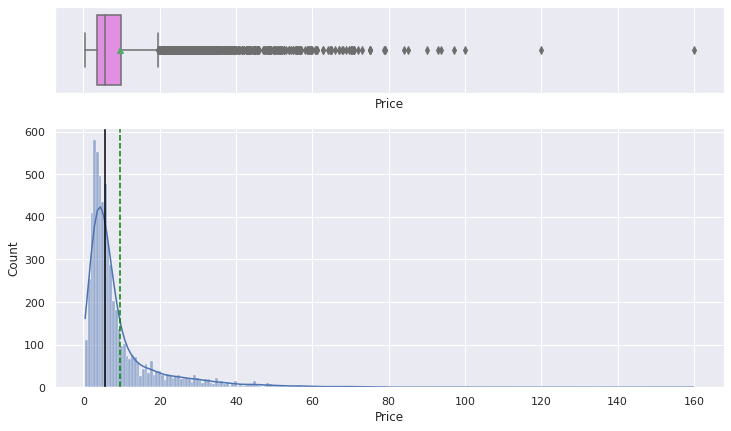

In [ ]:
histogram_boxplot(df, "Price", kde=True)

**Observations**

* This is a highly skewed distribution.
* Let us use log transformation on this column to see if that helps normalize the distribution.

In [ ]:
# Creating a new column with the transformed variable
df["price_log"] = np.log(df["Price"])

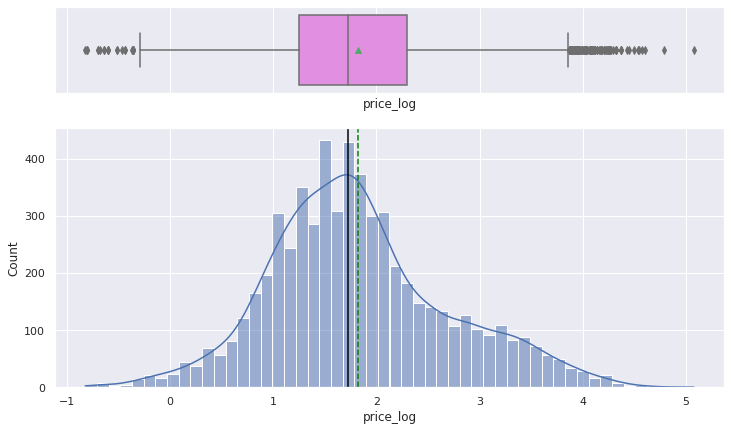

In [ ]:
histogram_boxplot(df, "price_log", kde=True)

* Using the log transformation has definitely helped in reducing the skew.

### `New_Price`

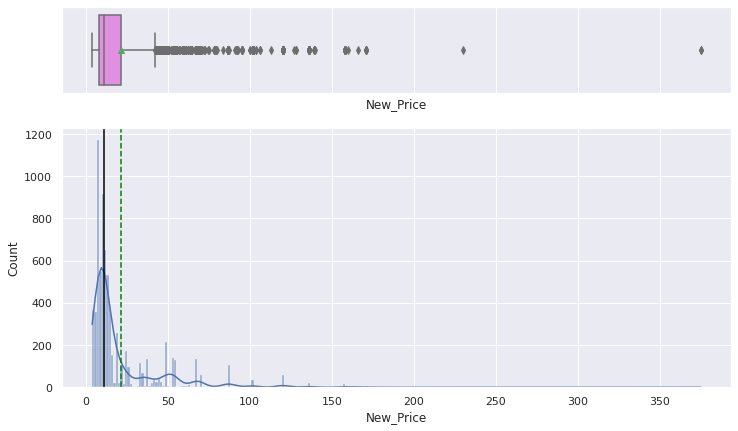

In [ ]:
histogram_boxplot(df, "New_Price", kde=True)

**Observations**

* This is another highly skewed distribution.
* Let us use log transformation on this column too.

In [ ]:
df["new_price_log"] = np.log(df["New_Price"])

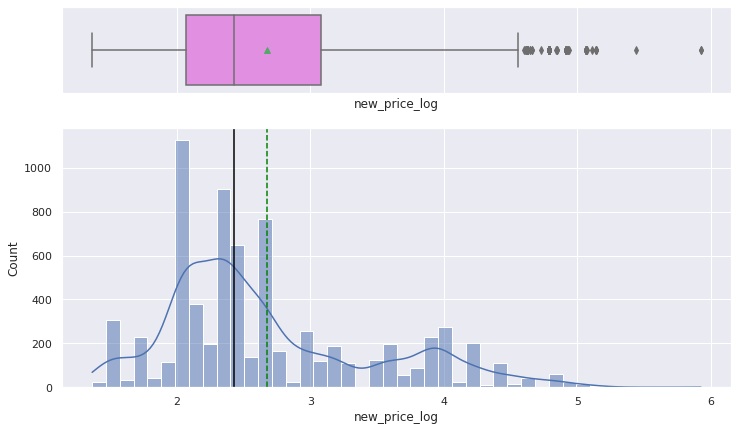

In [ ]:
histogram_boxplot(df, "new_price_log", kde=True)

* Transformation has reduced the extreme skewness.

### `Kilometers_Driven`

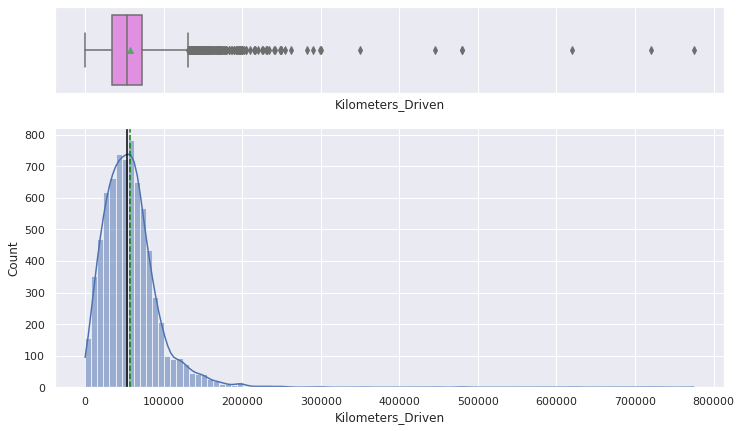

In [ ]:
histogram_boxplot(df, "Kilometers_Driven", bins=100, kde=True)

**Observations**

* This is another highly skewed distribution.
* Let us use log transformation on this column too.

In [ ]:
df["kilometers_driven_log"] = np.log(df["Kilometers_Driven"])

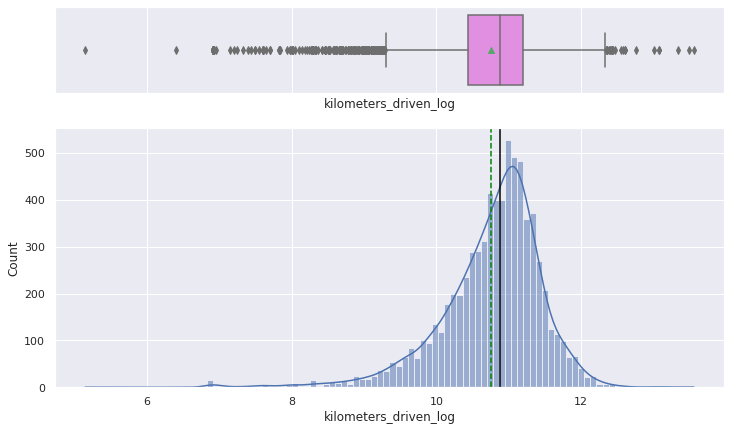

In [ ]:
histogram_boxplot(df, "kilometers_driven_log", bins=100, kde=True)

* Transformation has reduced the extreme skewness.

### `mileage_num`

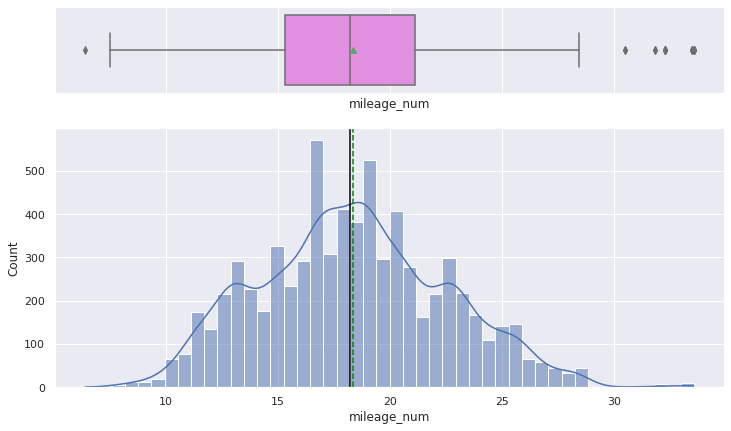

In [ ]:
histogram_boxplot(df, "mileage_num", kde=True)

**Observations**

* This is a close to normally distributed attribute.

### `engine_num`

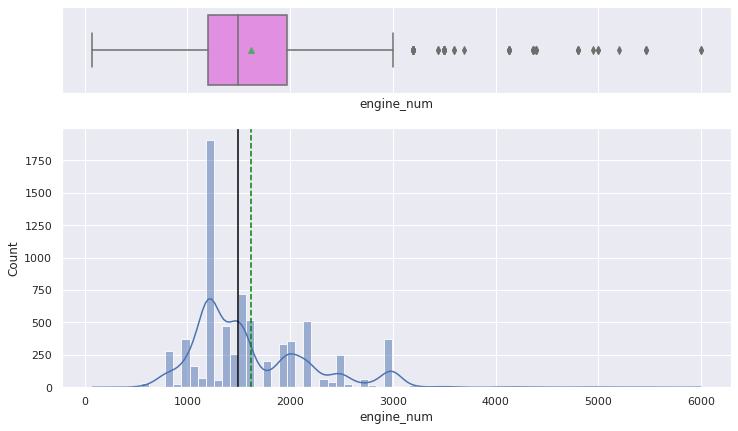

In [ ]:
histogram_boxplot(df, "engine_num", kde=True)

**Observations**

* There are a few car with a higher engine displacement volume.

### `power_num`

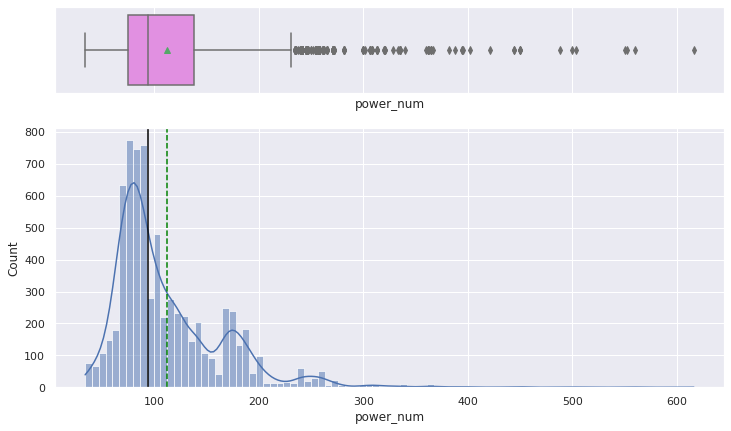

In [ ]:
histogram_boxplot(df, "power_num", kde=True)

**Observations**

* There are a few car with a higher engine power.

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### `Brand`

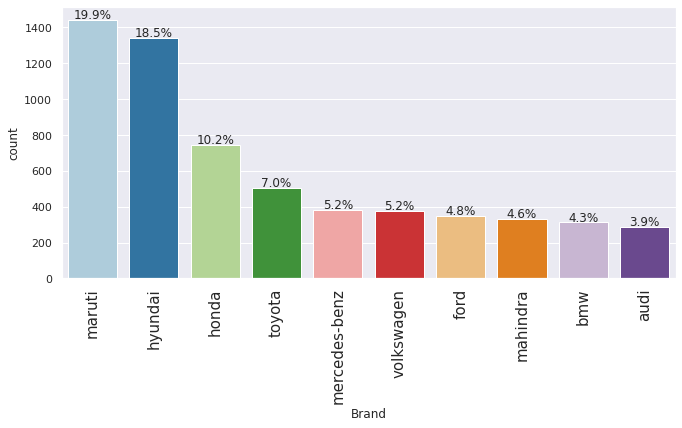

In [ ]:
labeled_barplot(df, "Brand", perc=True, n=10)

* Most of the cars in the data belong to Maruti or Hyundai.

### `Model`

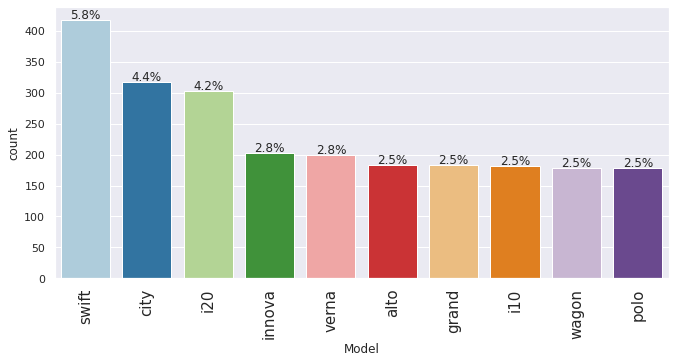

In [ ]:
labeled_barplot(df, "Model", perc=True, n=10)

**Observations**

* Maruti Swift is the most common car up for resale.

* It is clear from the above charts that our dataset contains used cars from luxury as well as budget-friendly brands.

* We can create a new variable using this information. We can consider binning all our cars into the following 3 categories later:

    1. Budget-Friendly
    2. Mid Range
    3. Luxury Cars

### `Seats`

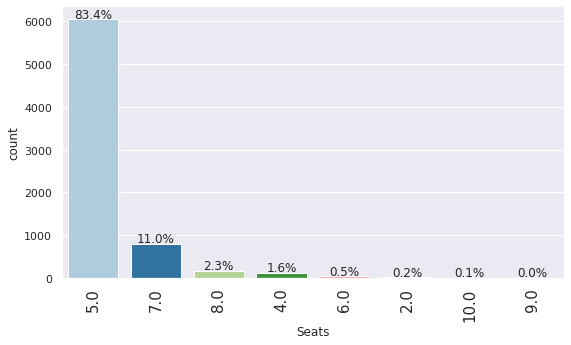

In [ ]:
labeled_barplot(df, "Seats", perc=True)

* 84% of the cars in the dataset are 5-seater cars.

### `Year`

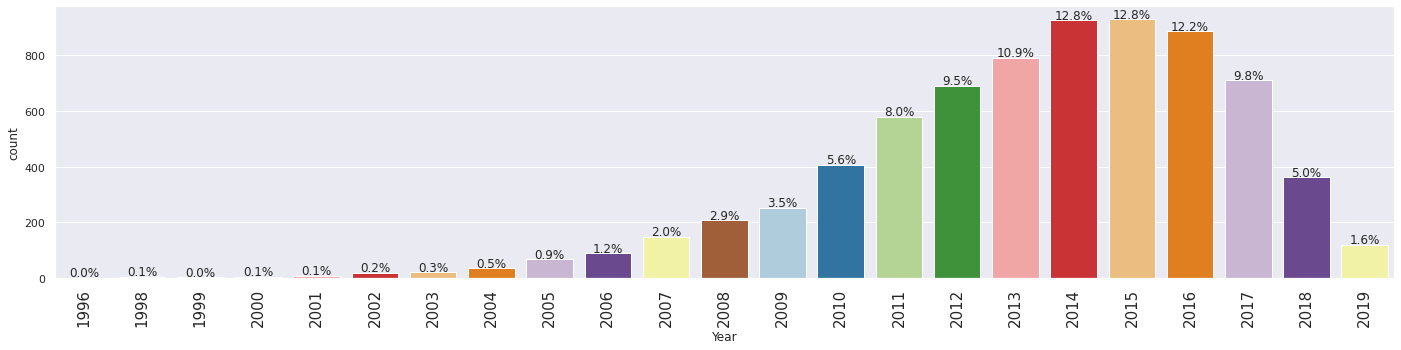

In [ ]:
labeled_barplot(df, "Year", perc=True)

* More than half the cars in the data were manufactured in or after 2014.

### `Location`

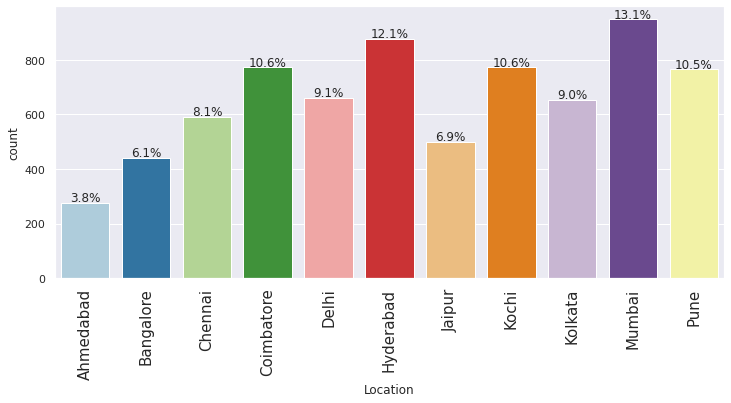

In [ ]:
labeled_barplot(df, "Location", perc=True)

* Hyderabad and Mumbai have the most demand for used cars.

### `Transmission`

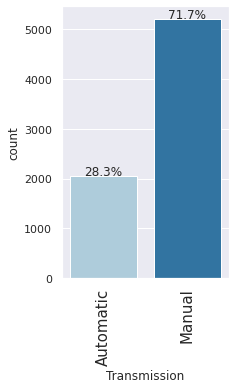

In [ ]:
labeled_barplot(df, "Transmission", perc=True)

* More than 70% of the cars have manual transmission.

### `Fuel_Type`

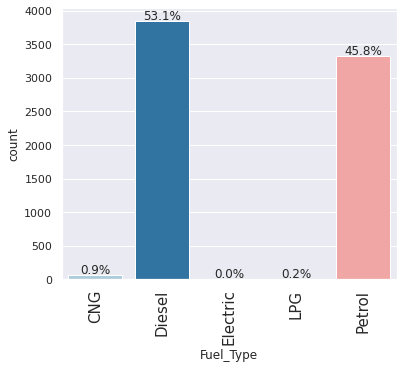

In [ ]:
labeled_barplot(df, "Fuel_Type", perc=True)

* Around 1% of the cars in the dataset do not run on diesel or petrol.

### `Owner_Type`

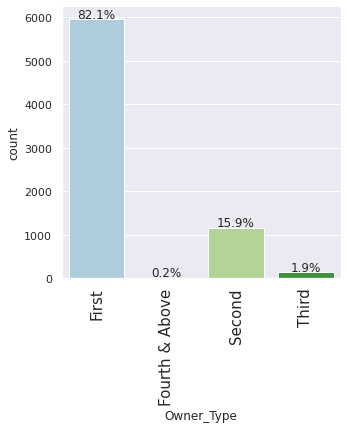

In [ ]:
labeled_barplot(df, "Owner_Type", perc=True)

* More than 80% of the used cars are being sold for the first time.

In [ ]:
# dropping the redundant columns
df.drop(columns=["Name", "mileage_unit"], inplace=True)

### Bivariate Distributions

**Let's check the correlation between numerical variables.**

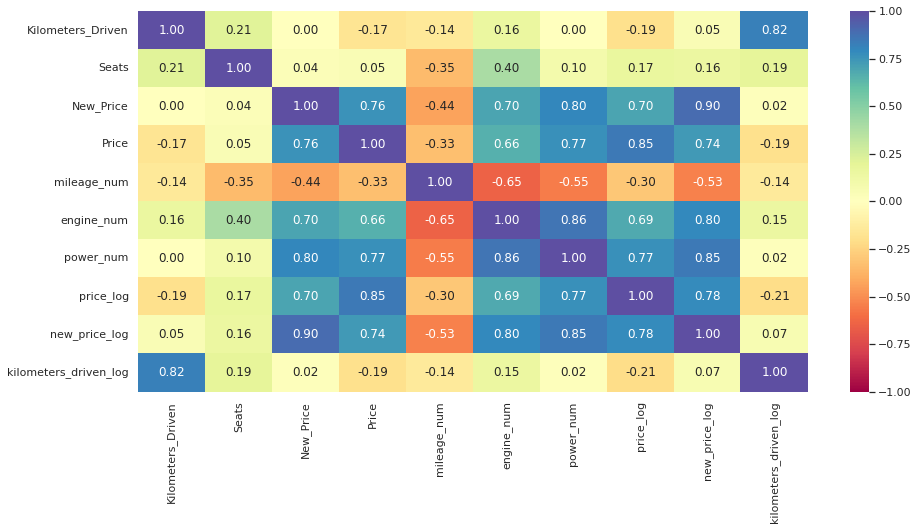

In [ ]:
cols_list = df.select_dtypes(include=np.number).columns.tolist()
# dropping Year as it is a temporal variable
cols_list.remove("Year")

plt.figure(figsize=(15, 7))
sns.heatmap(
    df[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

**Observations**

* `Power` and `Engine` are important predictors of used car price, but they are also highly correlated to each other.
* The price of a new car of the same model seems to be an important predictor of the used car price, which makes sense.

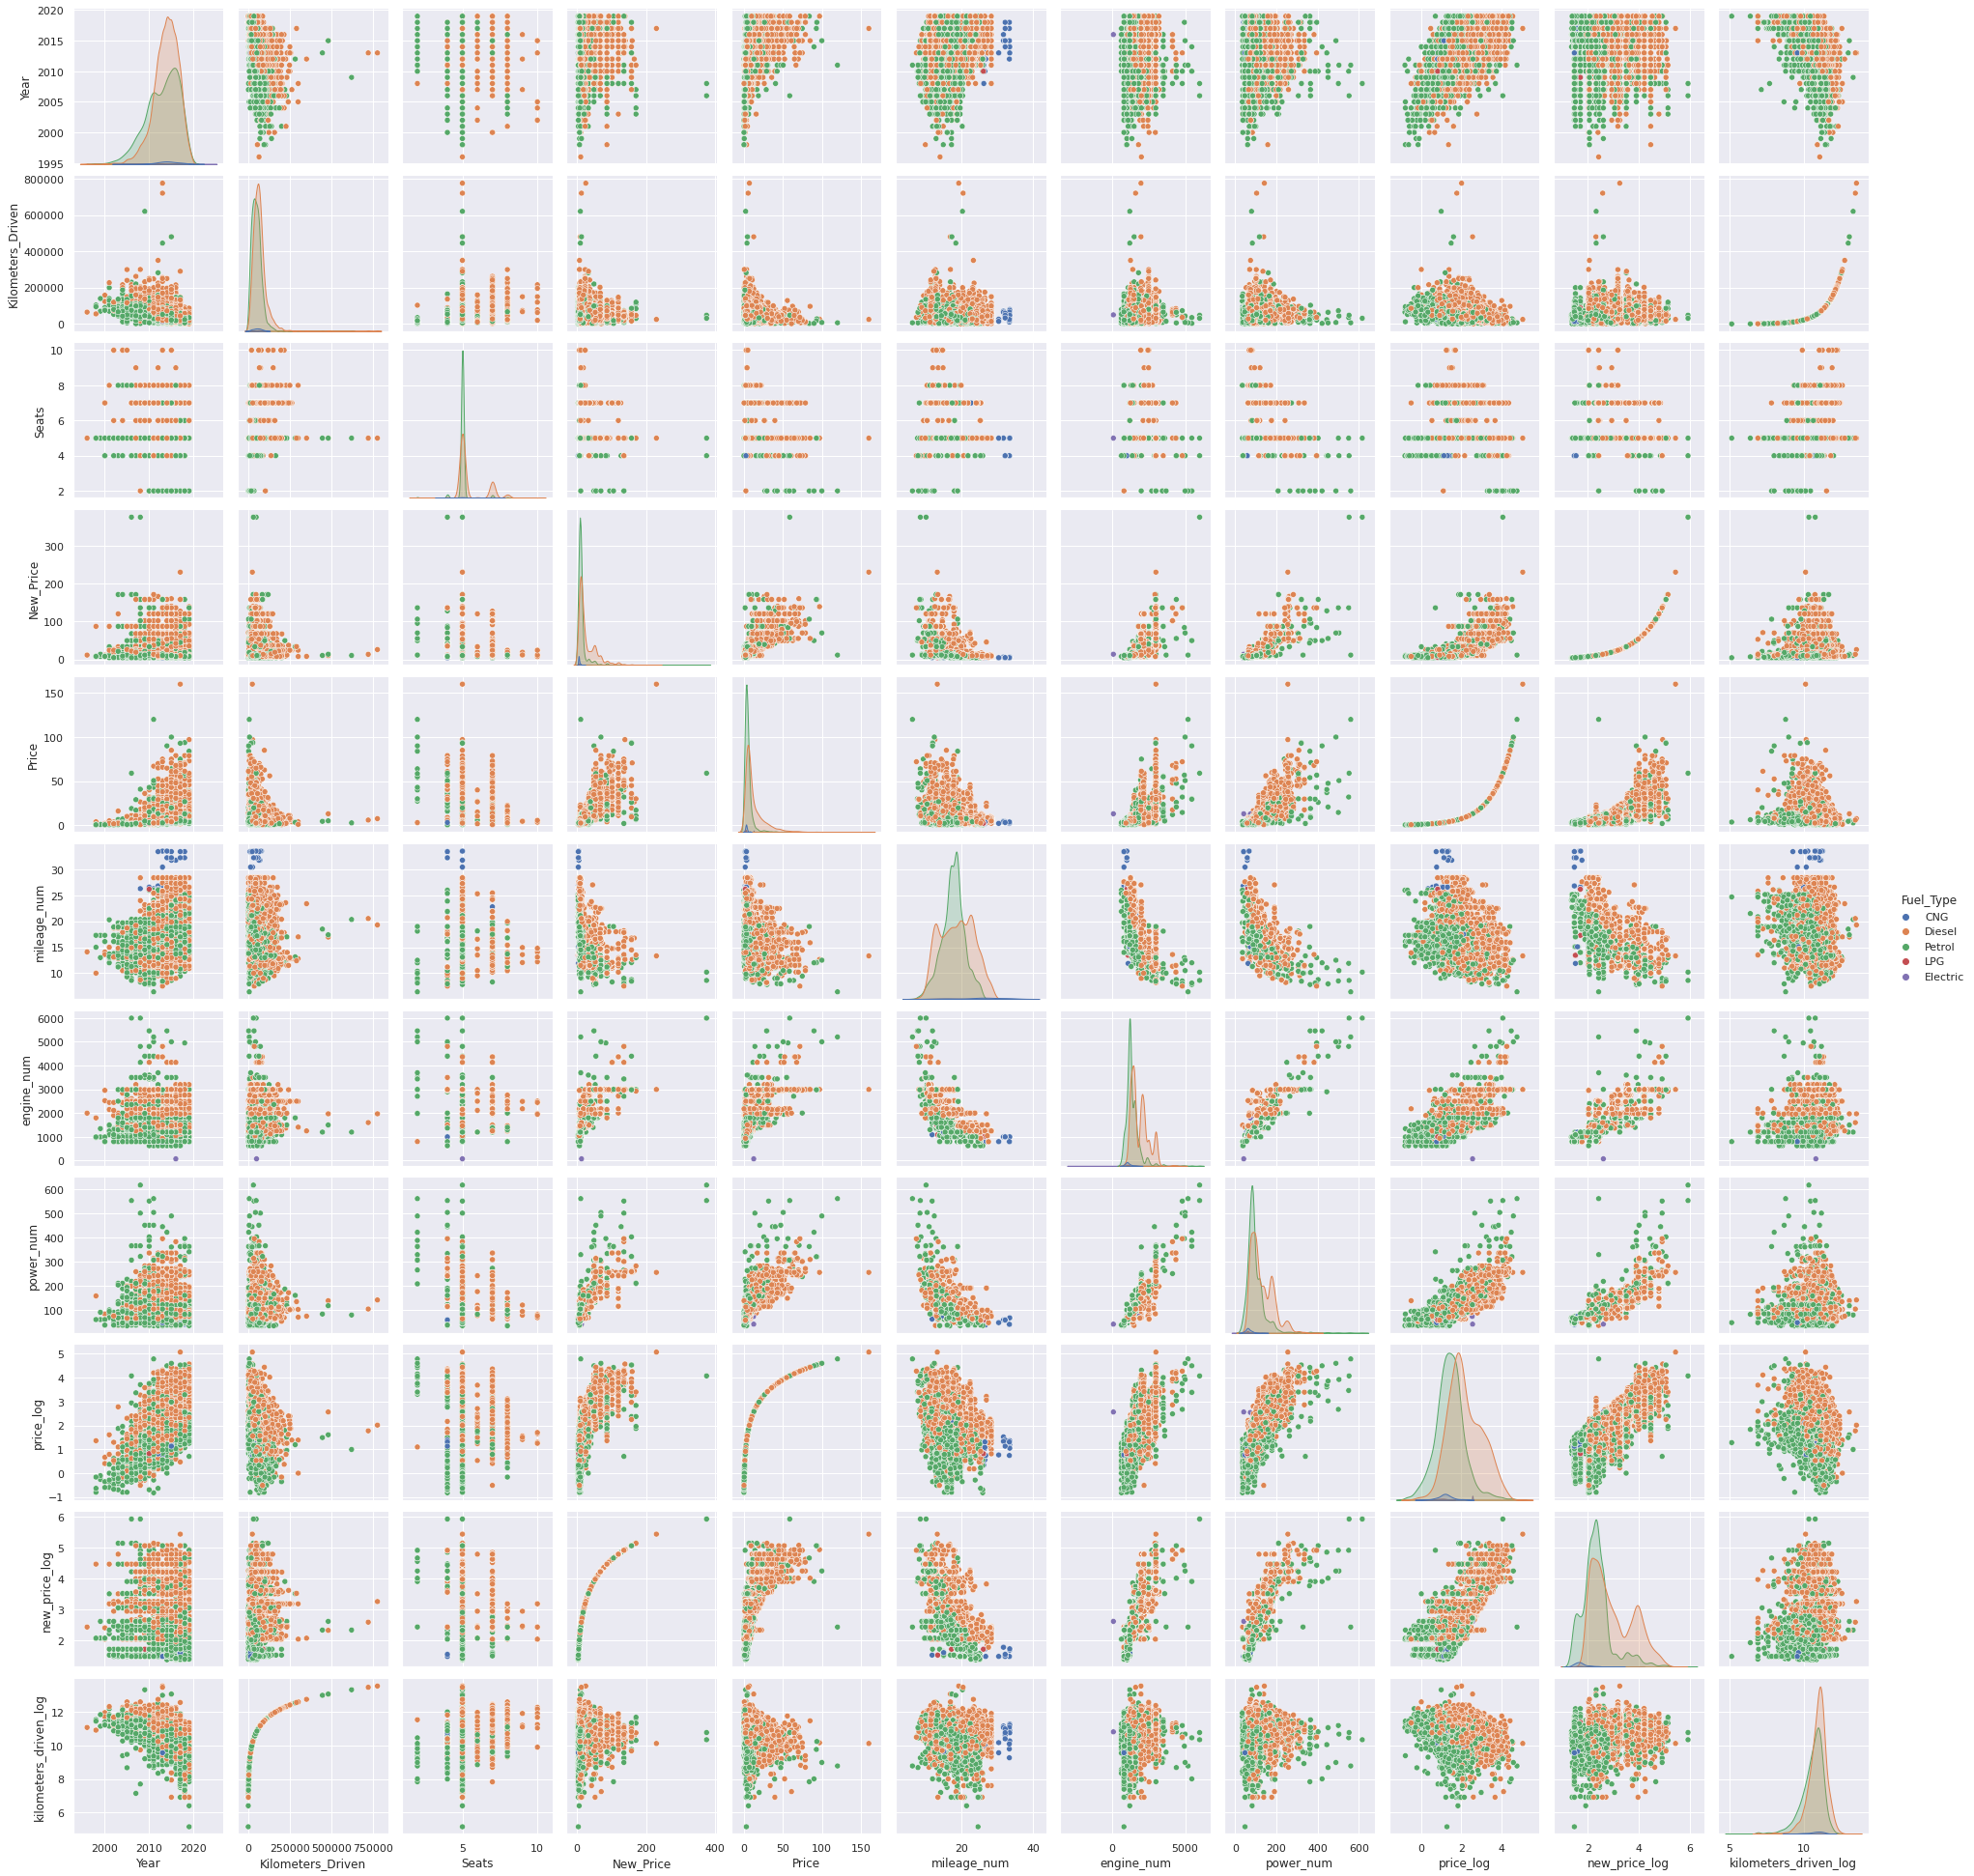

In [ ]:
sns.pairplot(data=df, hue="Fuel_Type")
plt.show()

**Observations**

Zooming into these plots gives us a lot of information.

- Contrary to intuition, `Kilometers_Driven` does not seem to have a relationship with the price.
- `Price` has a positive relationship with `Year`, i.e., the newer the car, the higher the price.
    - The temporal element of variation is captured in the year column.

- 2 seater cars are all luxury variants. Cars with 8-10 seats are exclusively mid to high range.
- Mileage does not seem to show much relationship with the price of used cars.
- Engine displacement and power of the car have a positive relationship with the price.
- `New_Price` and used car price are also positively correlated, which is expected.
- `Kilometers_Driven` has a peculiar relationship with the `Year` variable. Generally, the newer the car lesser the distance it has traveled, but this is not always true.
- CNG cars are conspicuous outliers when it comes to `Mileage`. The mileage of these cars is very high.
- The mileage and power of newer cars are increasing owing to advancements in technology.
- Mileage has a negative correlation with engine displacement and power. More powerful the engine, the more fuel it consumes in general.

**Let's check the variation in Price with some of the other variables.**

**`Price` vs `Location`**

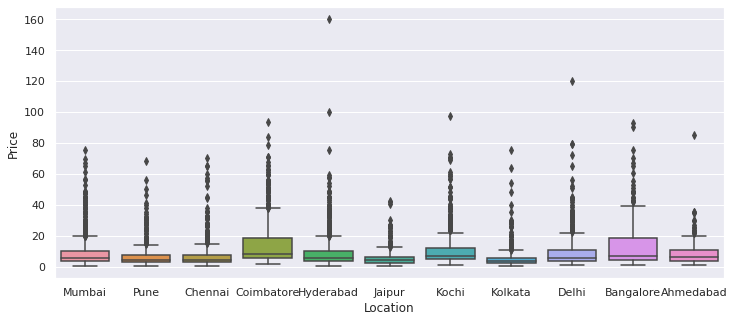

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="Location", y="Price", data=df)
plt.show()

* The price of used cars has a large IQR in Coimbatore and Bangalore.

**`Price` vs `Year`**

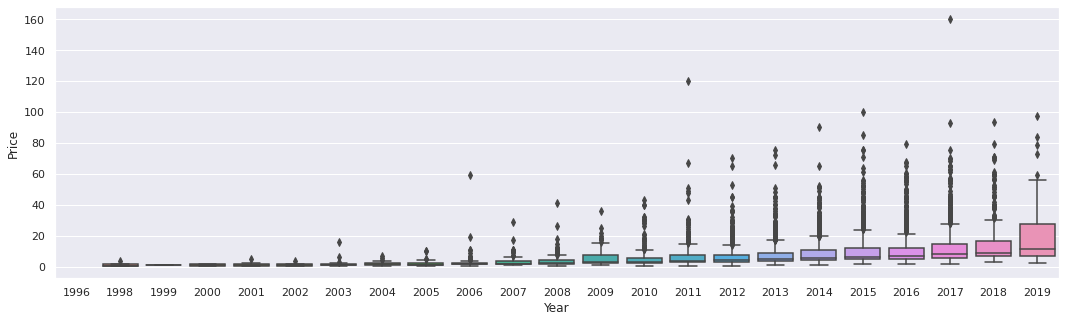

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(x="Year", y="Price", data=df)
plt.show()

* The price of used cars has increased over the years.

**`Price` vs `Brand`**

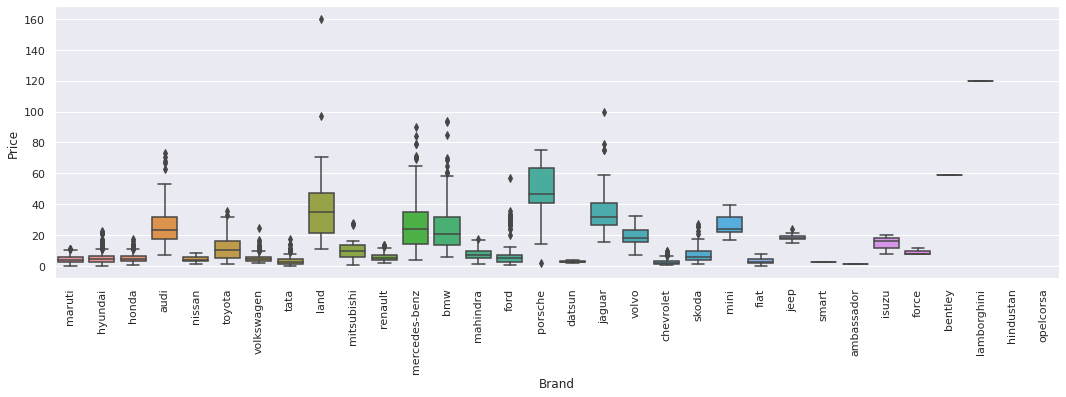

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(x="Brand", y="Price", data=df)
plt.xticks(rotation=90)
plt.show()

* The price of used cars is lower for budget brands like Maruti, Tata, Fiat, etc.
* The price of used cars is higher for premium brands like Porsche, Audi, Lamborghini, etc.

**`Price` vs `Transmission`**

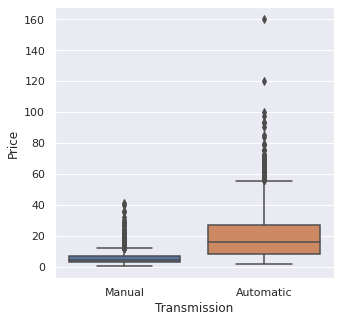

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(x="Transmission", y="Price", data=df)
plt.show()

* The price is higher for used cars with automatic transmission.

**`Price` vs `Fuel_Type`**

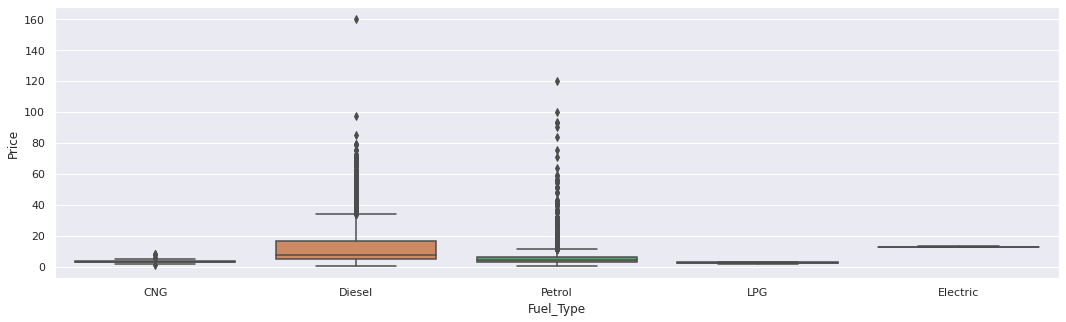

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(x="Fuel_Type", y="Price", data=df)
plt.show()

* Electric cars have the highest median price, followed by diesel cars.

**`Price` vs `Owner_Type`**

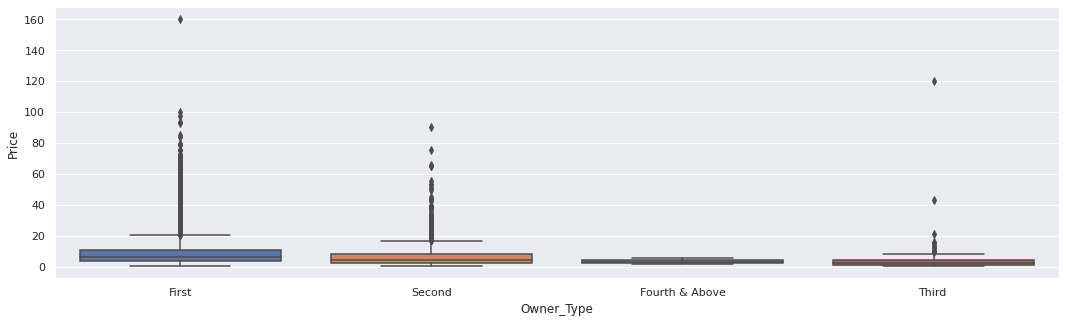

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(x="Owner_Type", y="Price", data=df)
plt.show()

* The price of cars decreases as they keep getting resold.

## Data Preprocessing (contd.)

### Missing Value Treatment

In [ ]:
# let's check again for missing values
df.isnull().sum()

Location                    0
Year                        0
Kilometers_Driven           1
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Seats                      53
New_Price                   0
Price                    1233
mileage_num                83
engine_num                 46
power_num                 175
Brand                       0
Model                       0
price_log                1233
new_price_log               0
kilometers_driven_log       1
dtype: int64

**Let's look at a few rows where number of seats is missing.**

In [ ]:
df[df["Seats"].isnull()].head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,engine_num,power_num,Brand,Model,price_log,new_price_log,kilometers_driven_log
194,Ahmedabad,2007,60006.0,Petrol,Manual,First,NaN,13.58,2.95,NaN,NaN,NaN,honda,city,1.081805,2.608598,11.002200
208,Kolkata,2010,42001.0,Petrol,Manual,First,NaN,7.88,2.11,16.1,NaN,NaN,maruti,swift,0.746688,2.064328,10.645449
229,Bangalore,2015,70436.0,Diesel,Manual,First,NaN,7.65,3.60,NaN,1498.0,99.0,ford,figo,1.280934,2.034706,11.162460
733,Chennai,2006,97800.0,Petrol,Manual,Third,NaN,7.88,1.75,16.1,NaN,NaN,maruti,swift,0.559616,2.064328,11.490680
749,Mumbai,2008,55001.0,Diesel,Automatic,Second,NaN,120.00,26.50,NaN,NaN,NaN,land,rover,3.277145,4.787492,10.915107


**We'll impute these missing values one-by-one by taking the median number of seats for the particular car using the `Brand` and `Model`.**

In [ ]:
df.groupby(["Brand", "Model"], as_index=False)["Seats"].median()

,Brand,Model,Seats
0,ambassador,classic,5.0
1,audi,a3,5.0
2,audi,a4,5.0
3,audi,a6,5.0
4,audi,a7,5.0
...,...,...,...
217,volvo,s60,5.0
218,volvo,s80,5.0
219,volvo,v40,5.0
220,volvo,xc60,5.0


In [ ]:
# imputing missing values in Seats
df["Seats"] = df.groupby(["Brand", "Model"])["Seats"].transform(
    lambda x: x.fillna(x.median())
)

In [ ]:
# Checking missing values in Seats
df[df["Seats"].isnull()]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,mileage_num,engine_num,power_num,Brand,Model,price_log,new_price_log,kilometers_driven_log
2369,Chennai,2008,56000.0,Petrol,Manual,Second,NaN,7.88,1.50,19.5,1061.0,NaN,maruti,estilo,0.405465,2.064328,10.933107
3882,Kolkata,2010,40000.0,Petrol,Manual,Second,NaN,7.88,2.50,19.5,1061.0,NaN,maruti,estilo,0.916291,2.064328,10.596635
5893,Chennai,2008,51000.0,Petrol,Manual,Second,NaN,7.88,1.75,19.5,1061.0,NaN,maruti,estilo,0.559616,2.064328,10.839581


* Maruti Estilo can accommodate 5 people.

In [ ]:
df["Seats"] = df["Seats"].fillna(5.0)

**We will use a similar method to fill missing values for the `Kilometers_Driven`, `mileage_num`, `engine_num`, and `power_num` columns.**

In [ ]:
cols_list = ["Kilometers_Driven", "mileage_num", "engine_num", "power_num"]

for col in cols_list:
    df[col] = df.groupby(["Brand", "Model"])[col].transform(
        lambda x: x.fillna(x.median())
    )

df.isnull().sum()

Location                    0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Seats                       0
New_Price                   0
Price                    1233
mileage_num                 9
engine_num                  0
power_num                  12
Brand                       0
Model                       0
price_log                1233
new_price_log               0
kilometers_driven_log       1
dtype: int64

* There are still some missing values in `mileage_num` and `power_num`.
* We'll impute these missing values by taking the median grouped by the `Brand`.

In [ ]:
cols_list = ["mileage_num", "power_num"]

for col in cols_list:
    df[col] = df.groupby(["Brand"])[col].transform(lambda x: x.fillna(x.median()))

df.isnull().sum()

Location                    0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Seats                       0
New_Price                   0
Price                    1233
mileage_num                 1
engine_num                  0
power_num                   2
Brand                       0
Model                       0
price_log                1233
new_price_log               0
kilometers_driven_log       1
dtype: int64

* There are still some missing values in `mileage_num` and `power_num`.
* We'll impute these missing values using the column median across the entire data.

In [ ]:
cols_list = ["mileage_num", "power_num"]

for col in cols_list:
    df[col] = df[col].fillna(df[col].median())

df.isnull().sum()

Location                    0
Year                        0
Kilometers_Driven           0
Fuel_Type                   0
Transmission                0
Owner_Type                  0
Seats                       0
New_Price                   0
Price                    1233
mileage_num                 0
engine_num                  0
power_num                   0
Brand                       0
Model                       0
price_log                1233
new_price_log               0
kilometers_driven_log       1
dtype: int64

- Missing values in all columns except `Price`, `price_log`, and `kilometers_driven_log` are imputed.
- We will drop the rows where `Price` is missing as it is the target variable.
- We will reapply the log transform to the `Kilometers_Driven` column.

In [ ]:
# dropping missing values in Price column
df = df[df["Price"].notna()]

# reapplying the log transform to the new_price_num column.
df["kilometers_driven_log"] = np.log(df["Kilometers_Driven"])

# checking for missing values
df.isnull().sum()

Location                 0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Seats                    0
New_Price                0
Price                    0
mileage_num              0
engine_num               0
power_num                0
Brand                    0
Model                    0
price_log                0
new_price_log            0
kilometers_driven_log    0
dtype: int64

- All missing values are dealt with.

In [ ]:
# dropping the redundant columns
df.drop(columns=["Kilometers_Driven"], inplace=True)

### <a id='link1'>Summary of EDA</a>

**Data Description:**

- The target variable (`Price`) is of *float* type.
- `Fuel_Type`, `Transmission`, and `Owner` are of *object* type.
- `Mileage`, `Engine`, `Power`, and `New_Price` are *object* type columns when they should ideally be numerical.
- All other columns are numeric in nature.
- There is one duplicate value in the data, which was dropped.
- There are a lot of missing values in the data.


**Data Cleaning:**

- The `Sl.No` column is dropped as it is a unique identifier for rows and does not add any value to the analysis.
- The `Mileage`, `Engine`, and `Power` columns were converted from string to numeric by extracting numerical values and discarding the units.
- `Brand` and `Model` were extracted from the `Name` column and the original column was then dropped.
- Anomalous values in columns like `Mileage`, `Seats`, and `Kilometers_driven` were treated as missing values.
- The missing values in the data are treated as follows:
    - Missing values in the target variable `Price` were dropped.
    - Missing values in numerical columns were imputed by the median values grouped by the `Brand` and `Model` name. Remaining missing values in these columns, if any, were imputed by the median values grouped by the `Brand` name. Any leftover missing values were imputed by column medians over entire data.


**Observations from EDA:**

- `Price`: The price of a used car is the target variable and has a highly skewed distribution, with a median value of around 53.5 lakh INR. The log transformation was applied on this column to reduce skewness. The displacement volume of the engine, the maximum power of the engine and the price of a new car of the same model is highly correlated with the price of a used car.
- `Mileage`: This attribute has a close to normally distribution. With increase in mileage, the engine displacement and power decrease.
- `Engine`: There are a few upper outliers, indicating that there are a few car with a higher engine displacement volume. Higher priced cars have higher engine displacement. It is also highly correlated with the maximum engine power.
- `Power`: There are a few upper outliers, indicating that there are a few car with a higher power. Higher priced cars have higher maximum power. It is also highly correlated with the engine displacement volume.
- `Kilometers_driven`: The number of kilometers a used car is driven has a highly skewed distribution, with a median value of around 53.5 thousand. The log transformation was applied on this column to reduce skewness.
- `New_Price`: The price of a used car is the target variable and has a highly skewed distribution, with a median value of around 11.3 lakh INR. The log transformation was applied on this column to reduce skewness.
- `Seats`: 84% of the cars in the dataset are 5-seater cars.
- `Year`: More than half the cars in the data were manufactured in or after 2014. The price of used cars has increased over the years.
- `Brand`: Most of the cars in the data belong to Maruti or Hyundai. The price of used cars is lower for budget brands like Porsche, Bentley, Lamborghini, etc. The price of used cars is higher for premium brands like Maruti, Tata, Fiat, etc.
- `Model`: Maruti Swift is the most common car up for resale. The dataset contains used cars from luxury as well as budget-friendly brands.
- `Location`: Hyderabad and Mumbai have the most demand for used cars. The price of used cars has a large IQR in Coimbatore and Bangalore.
- `Fuel_Type`: Around 1% of the cars in the dataset do not run on diesel or petrol. Electric cars have the highest median price, followed by diesel cars.
- `Transmission`: More than 70% of the cars have manual transmission. The price is higher for used cars with automatic transmission.
- `Owner_Type`: More than 80% of the used cars are being sold for the first time. The price of cars decreases as they keep getting resold.

## Linear Model Building

1. We want to predict the used car price. As `Price` is a skewed variable, we will try building a model using both the actual variable and its normalized version `price_log`.
2. Before we proceed to build a model, we'll have to encode categorical features.
3. We'll split the data into train and test to be able to evaluate the model that we build on the train data.
4. We will build a Linear Regression model using the train data and then check it's performance.

### Model 1: Using `Price`

In [ ]:
df.columns

Index(['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Seats',
       'New_Price', 'Price', 'mileage_num', 'engine_num', 'power_num', 'Brand',
       'Model', 'price_log', 'new_price_log', 'kilometers_driven_log'],
      dtype='object')

In [ ]:
# defining the dependent and independent variables
X = df.drop(["Price", "price_log"], axis=1)
y = df["Price"]

In [ ]:
# creating dummy variables
X = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)

X.head()

,Year,Seats,New_Price,mileage_num,engine_num,power_num,new_price_log,kilometers_driven_log,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Brand_audi,Brand_bentley,Brand_bmw,Brand_chevrolet,Brand_datsun,Brand_fiat,Brand_force,Brand_ford,Brand_honda,Brand_hyundai,Brand_isuzu,Brand_jaguar,Brand_jeep,Brand_lamborghini,Brand_land,Brand_mahindra,Brand_maruti,Brand_mercedes-benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_porsche,Brand_renault,Brand_skoda,Brand_smart,Brand_tata,Brand_toyota,Brand_volkswagen,Brand_volvo,Model_1000,Model_3,Model_5,Model_6,Model_7,Model_800,Model_a,Model_a-star,Model_a3,Model_a4,Model_a6,Model_a7,Model_a8,Model_accent,Model_accord,Model_alto,Model_amaze,Model_ameo,Model_aspire,Model_aveo,Model_avventura,Model_b,Model_baleno,Model_beat,Model_beetle,Model_bolero,Model_bolt,Model_boxster,Model_br-v,Model_brio,Model_brv,Model_c-class,Model_camry,Model_captiva,Model_captur,Model_cayenne,Model_cayman,Model_cedia,Model_celerio,Model_ciaz,Model_city,Model_civic,Model_cla,Model_classic,Model_cls-class,Model_clubman,Model_compass,Model_continental,Model_cooper,Model_corolla,Model_countryman,Model_cr-v,Model_creta,Model_crosspolo,Model_cruze,Model_d-max,Model_duster,Model_dzire,Model_e,Model_e-class,Model_ecosport,Model_eeco,Model_elantra,Model_elite,Model_endeavour,Model_enjoy,Model_eon,Model_ertiga,Model_esteem,Model_estilo,Model_etios,Model_evalia,Model_f,Model_fabia,Model_fiesta,Model_figo,Model_fluence,Model_fortuner,Model_fortwo,Model_freestyle,Model_fusion,Model_gallardo,Model_getz,Model_gl-class,Model_gla,Model_glc,Model_gle,Model_gls,Model_go,Model_grand,Model_grande,Model_hexa,Model_i10,Model_i20,Model_ignis,Model_ikon,Model_indica,Model_indigo,Model_innova,Model_jazz,Model_jeep,Model_jetta,Model_koleos,Model_kuv,Model_kwid,Model_lancer,Model_laura,Model_linea,Model_lodgy,Model_logan,Model_m-class,Model_manza,Model_micra,Model_mobilio,Model_montero,Model_mustang,Model_mux,Model_nano,Model_new,Model_nexon,Model_nuvosport,Model_octavia,Model_omni,Model_one,Model_optra,Model_outlander,Model_pajero,Model_panamera,Model_passat,Model_petra,Model_platinum,Model_polo,Model_prius,Model_pulse,Model_punto,Model_q3,Model_q5,Model_q7,Model_qualis,Model_quanto,Model_r-class,Model_rapid,Model_redi,Model_redi-go,Model_renault,Model_ritz,Model_rover,Model_rs5,Model_s,Model_s-class,Model_s-cross,Model_s60,Model_s80,Model_safari,Model_sail,Model_santa,Model_santro,Model_scala,Model_scorpio,Model_siena,Model_sl-class,Model_slc,Model_slk-class,Model_sonata,Model_spark,Model_ssangyong,Model_sumo,Model_sunny,Model_superb,Model_swift,Model_sx4,Model_tavera,Model_teana,Model_terrano,Model_thar,Model_tiago,Model_tigor,Model_tiguan,Model_tt,Model_tucson,Model_tuv,Model_v40,Model_vento,Model_venture,Model_verito,Model_verna,Model_versa,Model_vitara,Model_wagon,Model_wr-v,Model_wrv,Model_x-trail,Model_x1,Model_x3,Model_x5,Model_x6,Model_xc60,Model_xc90,Model_xcent,Model_xe,Model_xenon,Model_xf,Model_xj,Model_xuv300,Model_xuv500,Model_xylo,Model_yeti,Model_z4,Model_zen,Model_zest
0,2010,5.0,5.51,26.60,998.0,58.16,1.706565,11.184421,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015,5.0,16.06,19.67,1582.0,126.20,2.776332,10.621327,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# splitting the data in 70:30 ratio for train to test data

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

Number of rows in train data = 4213
Number of rows in test data = 1806


In [ ]:
# fitting a linear model
lin_reg_model1 = LinearRegression()
lin_reg_model1.fit(x_train, y_train)

LinearRegression()

In [ ]:
# let us check the coefficients and intercept of the model

coef_df = pd.DataFrame(
    np.append(lin_reg_model1.coef_, lin_reg_model1.intercept_),
    index=x_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

,Coefficients
Year,0.880493
Seats,1.200042
New_Price,0.843870
mileage_num,-0.063263
engine_num,-0.003264
...,...
Model_yeti,1.247545
Model_z4,14.272806
Model_zen,2.819751
Model_zest,-3.305633


### Model Performance Check

* We will be using metric functions defined in sklearn for RMSE, MAE, and $R^2$.
* We will define a function to calculate MAPE and adjusted $R^2$.
    - The mean absolute percentage error (MAPE) measures the accuracy of predictions as a percentage, and can be calculated as the average absolute percent error for each predicted value minus actual values divided by actual values. It works best if there are no extreme values in the data and none of the actual values are 0.

In [ ]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model1_perf_train = model_performance_regression(
    lin_reg_model1, x_train, y_train
)
lin_reg_model1_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.001427,2.216146,0.874781,0.866374,43.397131


* Both the R-squared and Adjusted R squared of our model are very high. This is a clear indication that we have been able to create a very good model that is able to explain variance in the price of used cars up to 87%.

* The model is not an underfitting model.

* Let's do a quick performance check on the test data.

In [ ]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model1_perf_test = model_performance_regression(lin_reg_model1, x_test, y_test)
lin_reg_model1_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.663588,2.444658,0.816857,0.785342,43.553368


* Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) of train and test data are close, which indicates that our model is not overfitting the train data.

* MAE indicates that our current model is able to predict used car prices within a mean error of 4.7 lakhs on test data.

* The units of both RMSE and MAE are the same, Lakhs in this case. But RMSE is greater than MAE because it penalizes the outliers more.

* MAPE of 43.55 on the test data indicates that the model can predict within ~44% of the used car price.

### Model 2: Using `price_log`

In [ ]:
# defining the dependent and independent variables
X = df.drop(["Price", "price_log"], axis=1)
y = df["price_log"]

# creating dummy variables
X = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),
    drop_first=True,
)

# splitting the data in 70:30 ratio for train to test data

x_train2, x_test2, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

print("Number of rows in train data =", x_train2.shape[0])
print("Number of rows in test data =", x_test2.shape[0])

Number of rows in train data = 4213
Number of rows in test data = 1806


In [ ]:
# fitting a linear model
lin_reg_model2 = LinearRegression()
lin_reg_model2.fit(x_train2, y_train)

LinearRegression()

In [ ]:
# let us check the coefficients and intercept of the model

coef_df = pd.DataFrame(
    np.append(lin_reg_model2.coef_, lin_reg_model2.intercept_),
    index=x_train2.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

,Coefficients
Year,0.106123
Seats,0.003229
New_Price,0.006483
mileage_num,0.000898
engine_num,-0.000122
...,...
Model_yeti,0.246354
Model_z4,0.811129
Model_zen,-0.426071
Model_zest,-0.382085


### Model Performance Check

* We will check the model performance on the actual prices and not the log values.
* We will create a function that will convert the log prices to actual prices and then check the performance.
* We will be using metric functions defined in sklearn for RMSE, MAE, and $R^2$.
* We will define a function to calculate MAPE and adjusted $R^2$.

In [ ]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    # computing the actual prices by using the exponential function
    target = np.exp(target)
    pred = np.exp(pred)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model2_perf_train = model_performance_regression(
    lin_reg_model2, x_train2, y_train
)
lin_reg_model2_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,2.737514,1.197035,0.941392,0.937458,12.97992


In [ ]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model2_perf_test = model_performance_regression(lin_reg_model2, x_test2, y_test)
lin_reg_model2_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.184134,1.326293,0.914625,0.899933,12.955532


* Both the R-squared and Adjusted R squared of our model are higher than before and the model is able to explain up to 94% of the variance in the price of used cars.
* RMSE and MAE of train and test data are close, and are much lower than what we got from the previous models.
* MAE indicates that our current model is able to predict used car prices within a mean error of 1.3 lakhs on test data.
* MAPE of 12.96 on the test data indicates that the model can predict within ~13% of the used car price.

### Model Comparison

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        lin_reg_model1_perf_train.T,
        lin_reg_model2_perf_train.T,
    ],
    axis=1,
)

models_train_comp_df.columns = [
    "Linear Regression (Price)",
    "Linear Regression (price_log)",
]

print("Training performance comparison:")
models_train_comp_df

In [ ]:
# test performance comparison

models_test_comp_df = pd.concat(
    [
        lin_reg_model1_perf_test.T,
        lin_reg_model2_perf_test.T,
    ],
    axis=1,
)

models_test_comp_df.columns = [
    "Linear Regression (Price)",
    "Linear Regression (price_log)",
]

print("Test performance comparison:")
models_test_comp_df

**We will consider *lin_reg_model2* (model using `price_log` as target) as our final model.**

## Observations

1. With our linear regression model *lin_reg_model2*, we have been able to capture ~94% of the variation in the data.


2. MAE indicates that our current model is able to predict used car prices within a mean error of approx. 1.32 lakhs on the test data, and the MAPE indicates that the model can predict within ~13% of the used car price.


3. Factors like the year of manufacture, numbers of seats, maximum power of the engine, few locations, few brands, etc. tend to increase the price of the used car.


4. Factors like distance volume of engine, log of the number of kilometers driven, few locations, few brands, etc. tend to decrease the price of the used car.

## Business Insights and Recommendations

* Cars with a lesser number of kilometers driven should be preferred. 


* Some markets tend to have higher prices. Cars4U should focus more on these markets, and set up offices in these areas if needed.


* We will have to analyze the cost side of things before we can talk about profitability in the business. We should gather data regarding that.


* The next step post that would be to cluster different sets of data and see if we should make multiple models for different locations/car types.

## Add-on: Analysing predictions where we were way off the mark

In [ ]:
# Extracting the rows from original data frame df where indexes are same as the training data
original_df = df[df.index.isin(x_train2.index.values)].copy()

# Extracting predicted values and residuals from the final model
fitted_values = lin_reg_model2.predict(x_train2)
residuals = fitted_values - y_train

# Add new columns for predicted values
original_df["Predicted price_log "] = fitted_values
original_df["Predicted Price"] = np.exp(fitted_values)
original_df["residuals"] = residuals
original_df["Abs_residuals"] = np.exp(residuals)
original_df["Difference in Lakhs"] = np.abs(
    original_df["Price"] - original_df["Predicted Price"]
)

# Let us look at the top 10 predictions where our model made highest extimation errors (on train data)
original_df.sort_values(by=["Difference in Lakhs"], ascending=False).head(10)

**Observations**

* A 2017 Land Rover, whose new model sells at 230 Lakhs and the used version sold at 160 Lakhs was predicted to be sold at < 3 Lakhs. It is not apparent after looking at numerical predictors, why our model predicted such low value here. This could be because many other land rovers in our data seem to have sold at lower prices.

* Another entry in the list here is a Lamborghini Gallardo that was sold at 120 Lakhs but our model predicted the price around 3 lakhs. This is a huge error by the model. However, there might be a data entry error here as the price of a new Gallardo is set at around 11 Lakhs, which is less than the selling price of a used Gallardo.

* There are a few instances where the model predicts lesser than the actual selling price. These could be a cause for concern. The model predicting lesser than potential selling price is not good for business.

## Add-on: Advanced Data Preprocessing

In [ ]:
coeff1* feature1 (engine_num = 13) + coeff2* feature2 (power_num= 13) + ... intercept = Price(predicted prce) + (regularisation) = 20 lakhs --> 20 lakhs +- 12%

In [ ]:
mean ( abs(target- pred) /target   )

In [ ]:
0close to 0 -> non zero values

In [ ]:
ht->(6 , 100000/ft) 

In [ ]:
price -> 0.9 with new_price (leakage variable)
new_price -> price ------ 90% accurate

km_driven -- power_num (0.8) -> linear regression -> no multicollinarity (independent vars)  [VIF -> 5 indication]


In [ ]:
df = data.copy()

**1. `Mileage`**

* We have car mileage in two units as per the data dictionary - kmpl and km/kg.

* After quick research on the internet, it is clear that these 2 units are used for cars of 2 different fuel types.

    * kmpl (kilometers per litre) is used for petrol and diesel cars.
    * km/kg (kilometers per kg) is used for CNG and LPG-based engines.

* We have the variable `Fuel_type` in our data. Let us check if these observations hold true in our data also.

In [ ]:
# Create 2 new columns after splitting the mileage values.
mileage_num = []
mileage_unit = []

for observation in df["Mileage"]:
    if isinstance(observation, str):
        if (
            observation.split(" ")[0]
            .replace(".", "", 1)
            .isdigit()  # first element should be numeric
            and " " in observation  # space between numeric and unit
            and (
                observation.split(" ")[1]
                == "kmpl"  # units are limited to "kmpl" and "km/kg"
                or observation.split(" ")[1] == "km/kg"
            )
        ):
            mileage_num.append(float(observation.split(" ")[0]))
            mileage_unit.append(observation.split(" ")[1])
        else:
            # To detect if there are any observations in the column that do not follow
            # the expected format [number + ' ' + 'kmpl' or 'km/kg']
            print(
                "The data needs further processing. All values are not similar ",
                observation,
            )
    else:
        # If there are any missing values in the mileage column,
        # we add corresponding missing values to the 2 new columns
        mileage_num.append(np.nan)
        mileage_unit.append(np.nan)

* No print output from the function above. The values are all in the expected format or NaNs.

In [ ]:
# Add the new columns to the data

df["mileage_num"] = mileage_num
df["mileage_unit"] = mileage_unit

# Checking the new dataframe
df.head(5)

In [ ]:
# Let us check if the units correspond to the fuel types
df.groupby(by=["Fuel_Type", "mileage_unit"]).size()

* As expected, km/kg is for CNG/LPG cars and kmpl is for Petrol and Diesel cars.

**2. `Engine`**

* As per the data dictionary, the `Engine` column indicates the displacement volume of the engine in CC.

* We will make sure that all the observations follow the same format - [numeric + " " + "CC"] and create a new numeric column from this column.

* This time, let's use a regex to make all the necessary checks.

In [ ]:
# re module provides support for regular expressions
import re

# Create a new column after splitting the engine values.
engine_num = []

# Regex for numeric + " " + "CC"  format
regex_engine = "^\d+(\.\d+)? CC$"

for observation in df["Engine"]:
    if isinstance(observation, str):
        if re.match(regex_engine, observation):
            engine_num.append(float(observation.split(" ")[0]))
        else:
            # To detect if there are any observations in the column that do not follow [numeric + " " + "CC"]  format
            print(
                "The data needs furthur processing. All values are not similar ",
                observation,
            )
    else:
        # If there are any missing values in the engine column, we add missing values to the new column
        engine_num.append(np.nan)

* No print output from the function above. The values are all in the same format - [numeric + " " + "CC"] or NaNs.

In [ ]:
# Add the new column to the data
df["engine_num"] = engine_num

# Checking the new dataframe
df.head()

**3. `Power`**

* As per the data dictionary, the `Power` column indicates the maximum power of the engine in bhp.

* We will make sure that all the observations follow the same format - [numeric + " " + "bhp"] and create a new numeric column from this column like we did for the `Engine` column.

In [ ]:
# Create a new column after splitting the power values.
power_num = []

# Regex for numeric + " " + "bhp"  format
regex_power = "^\d+(\.\d+)? bhp$"

for observation in df["Power"]:
    if isinstance(observation, str):
        if re.match(regex_power, observation):
            power_num.append(float(observation.split(" ")[0]))
        else:
            # To detect if there are any observations in the column that do not follow [numeric + " " + "bhp"]  format
            # that we see in the sample output
            print(
                "The data needs furthur processing. All values are not similar ",
                observation,
            )
    else:
        # If there are any missing values in the power column, we add missing values to the new column
        power_num.append(np.nan)

* No print output from the function above. The values are all in the same format - [numeric + " " + "bhp"] or NaNs.

In [ ]:
# Add the new column to the data
df["power_num"] = power_num

# Checking the new dataframe
df.head()